In [226]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
norepo = 'no repository listed'
manualcheckup = 'manual checkup needed'
notgit = 'not git'

In [227]:
q = '''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
where commit_date is not null
and version!=%s;'''
df = pd.DataFrame(sql.execute(q,(manualcheckup)))
df['advisory_id'].nunique()

2497

In [228]:
#not present in Maven central repository
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
where commit_date is not null
and version!=%s
and fc.advisory_id not in
(select advisory_id
from fixing_releases fr
join advisory a on fr.advisory_id = a.id
join release_info ri on fr.version = ri.version and ri.package_id=a.package_id);'''
df = pd.DataFrame(sql.execute(q,(manualcheckup)))
df['package_id'].nunique(), df['advisory_id'].nunique()

(75, 145)

In [229]:
q='''select *
from fix_commits fc
join fixing_releases fr on fc.advisory_id = fr.advisory_id
join package p on fc.package_id = p.id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where commit_date is not null
and fr.version!='manual checkup needed'
and ri.publish_date is null;'''
df = pd.DataFrame(sql.execute(q))
df['ri.id'].nunique(), df['package_id'].nunique(), df['advisory_id'].nunique()

(357, 272, 341)

In [230]:
q = '''select advisory_id, count(distinct commit_sha)
from fix_commits
where commit_date is not null
group by advisory_id
having count(distinct commit_sha) > 1'''
df = pd.DataFrame(sql.execute(q))
len(df)

806

In [231]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))

In [232]:
q = '''select * from package_usage pu
join package p on pu.package_id = p.id'''
usage = pd.DataFrame(sql.execute(q))

In [233]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date, cve_date,
        earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
       concat(advisory_id, package_id, version) as total_release
        from
        (select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date, cve_date
        from advisory a
                left join (select advisory_id, min(C.publish_Date) as cve_date
        from advisoryCVE aC
        join CVE C on aC.cve = C.cve
        group by advisory_id) as ac
            on ac.advisory_id=a.id
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;
'''
df = pd.DataFrame(sql.execute(q))
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31 20:29:00,2016-09-07 04:46:51,2016-09-07 16:06:06,2016-09-07 16:39:10,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23 00:15:00,2021-01-13 22:15:05,2021-01-13 22:15:05,2021-01-25 16:29:19,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20 09:15:00,2020-08-15 00:25:54,2020-08-15 00:25:54,2021-02-04 05:30:00,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19 23:15:00,2020-04-13 17:49:08,2020-04-28 18:20:50,2020-05-04 19:47:00,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19 09:15:00,2021-01-13 23:19:50,2021-01-13 23:19:50,2021-02-03 19:50:00,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-1070809,3926,pip,Improper Authorization,M,2021-02-08,2021-02-09,NaT,2021-02-04 19:46:52,2021-02-04 19:46:52,2021-02-04 20:01:20,1.3.0,package3926version1.3.0,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-107080939261...
2785,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,2021-03-01 11:51:00,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0
2786,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,NaT,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23


In [234]:
len(df)
df['cve_date'] = df['cve_date'].dt.date
t1 = df[~df['cve_date'].isna()].copy()
t1['advisory_date'] = t1[['cve_date', 'publish_date']].min(axis=1)
t2 = df[df['cve_date'].isna()].copy()
t2['advisory_date'] = t2['publish_date']
df = pd.concat([t1, t2], ignore_index=True, sort=False)
len(df)

2789

In [235]:
def get_fix_commit_date(row):
    if row['earliest_fix_commit_date'] == row['latest_fix_commit_date']:
        return row['earliest_fix_commit_date']
    else:
        if row['latest_fix_commit_date'] <= row['release_date']:
            return row['latest_fix_commit_date']
        else:
            return row['earliest_fix_commit_date']

df['fix_commit_date'] = df.apply(get_fix_commit_date, axis=1)
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,advisory_date,fix_commit_date
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31,2016-09-07 04:46:51,2016-09-07 16:06:06,2016-09-07 16:39:10,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3,2016-09-09,2016-09-07 16:06:06
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23,2021-01-13 22:15:05,2021-01-13 22:15:05,2021-01-25 16:29:19,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,2021-02-23,2021-01-13 22:15:05
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20,2020-08-15 00:25:54,2020-08-15 00:25:54,2021-02-04 05:30:00,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating,2021-02-20,2020-08-15 00:25:54
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19,2020-04-13 17:49:08,2020-04-28 18:20:50,2020-05-04 19:47:00,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4,2021-02-19,2020-04-28 18:20:50
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19,2021-01-13 23:19:50,2021-01-13 23:19:50,2021-02-03 19:50:00,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14,2021-02-19,2021-01-13 23:19:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-1070809,3926,pip,Improper Authorization,M,2021-02-08,2021-02-09,NaT,2021-02-04 19:46:52,2021-02-04 19:46:52,2021-02-04 20:01:20,1.3.0,package3926version1.3.0,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-107080939261...,2021-02-09,2021-02-04 19:46:52
2785,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,2021-03-01 11:51:00,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0,2021-02-15,2021-01-26 14:00:30
2786,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,NaT,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-05,2019-06-04 23:23:04
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22,2019-01-22 08:42:56


In [236]:
df['fix_to_release_delay'] = (df['release_date'] - df['fix_commit_date']).dt.total_seconds()
df['fix_to_release_delay'] = round ( df['fix_to_release_delay'] / (3600 * 24))
df['disclose_to_fix_delay'] = (df['fix_commit_date'].dt.date - df['disclose_date']).dt.days
df['release_to_publish_delay'] = (df['advisory_date'] - df['release_date'].dt.date).dt.days
df['fix_to_publish_delay'] = (df['advisory_date'] - df['fix_commit_date'].dt.date).dt.days
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,advisory_date,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31,2016-09-07 04:46:51,2016-09-07 16:06:06,2016-09-07 16:39:10,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3,2016-09-09,2016-09-07 16:06:06,0.0,1,2,2
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23,2021-01-13 22:15:05,2021-01-13 22:15:05,2021-01-25 16:29:19,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,2021-02-23,2021-01-13 22:15:05,12.0,-41,29,41
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20,2020-08-15 00:25:54,2020-08-15 00:25:54,2021-02-04 05:30:00,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating,2021-02-20,2020-08-15 00:25:54,173.0,-190,16,189
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19,2020-04-13 17:49:08,2020-04-28 18:20:50,2020-05-04 19:47:00,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4,2021-02-19,2020-04-28 18:20:50,6.0,-299,291,297
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19,2021-01-13 23:19:50,2021-01-13 23:19:50,2021-02-03 19:50:00,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14,2021-02-19,2021-01-13 23:19:50,21.0,-37,16,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-1070809,3926,pip,Improper Authorization,M,2021-02-08,2021-02-09,NaT,2021-02-04 19:46:52,2021-02-04 19:46:52,2021-02-04 20:01:20,1.3.0,package3926version1.3.0,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-107080939261...,2021-02-09,2021-02-04 19:46:52,0.0,-4,5,5
2785,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,2021-03-01 11:51:00,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0,2021-02-15,2021-01-26 14:00:30,34.0,0,-14,20
2786,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,NaT,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-05,2019-06-04 23:23:04,0.0,0,1,1
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22,2019-01-22 08:42:56,0.0,0,0,0


In [237]:
df['advisory_id'].nunique(), df['fixing_release'].nunique(),  df['total_release'].nunique()

(2068, 2355, 2789)

In [238]:
total = len(df)
d2f = df[df['disclose_to_fix_delay'] > 0]
before = len(d2f)
d2f['disclose_to_fix_delay'].describe(), before/total


(count     781.000000
 mean       79.177977
 std       193.344665
 min         1.000000
 25%         2.000000
 50%         8.000000
 75%        42.000000
 max      1849.000000
 Name: disclose_to_fix_delay, dtype: float64,
 0.28002868411617066)

In [239]:
df['release_to_publish_delay'].describe()

count    2789.000000
mean      111.258516
std       389.495768
min     -2243.000000
25%         0.000000
50%         7.000000
75%        58.000000
max      4918.000000
Name: release_to_publish_delay, dtype: float64

In [240]:
wrong = df[df['fix_to_release_delay'] < 0]
wrong = wrong.sample(frac=1).reset_index(drop=True)
wrong.to_csv('delaylessthanzero.csv', index=False)
len(wrong)

149

In [241]:
temp = df[df['fix_to_publish_delay']<0]
temp = pd.merge(temp, ifcve)
temp

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,...,version,fixing_release,total_release,advisory_date,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay,ifcve
0,SNYK-JAVA-IOUNDERTOW-174583,85,Maven,Information Exposure,M,2018-09-18,2019-05-06,2018-09-18,2018-10-29 06:33:31,2018-10-29 06:33:31,...,1.4.27.Final,package85version1.4.27.Final,SNYK-JAVA-IOUNDERTOW-174583851.4.27.Final,2018-09-18,2018-10-29 06:33:31,78.0,41,-119,-41,cve
1,SNYK-JAVA-IOUNDERTOW-174583,85,Maven,Information Exposure,M,2018-09-18,2019-05-06,2018-09-18,2018-10-29 06:33:31,2018-10-29 06:33:31,...,2.0.15.Final,package85version2.0.15.Final,SNYK-JAVA-IOUNDERTOW-174583852.0.15.Final,2018-09-18,2018-10-29 06:33:31,0.0,41,-41,-41,cve
2,SNYK-JAVA-IOUNDERTOW-568918,85,Maven,Denial of Service (DoS),H,2020-05-11,2020-05-12,2020-06-10,2020-05-15 05:02:33,2020-05-15 05:06:07,...,2.1.1.Final,package85version2.1.1.Final,SNYK-JAVA-IOUNDERTOW-568918852.1.1.Final,2020-05-12,2020-05-15 05:06:07,0.0,4,-3,-3,cve
3,npm:electron:20180123,124,npm,Directory Traversal,H,2018-01-23,2018-01-25,2018-01-24,2018-03-15 05:23:49,2018-03-15 05:25:18,...,1.6.16,package124version1.6.16,npm:electron:201801231241.6.16,2018-01-24,2018-03-15 05:23:49,-51.0,51,1,-50,cve
4,npm:electron:20180123,124,npm,Directory Traversal,H,2018-01-23,2018-01-25,2018-01-24,2018-03-15 05:23:49,2018-03-15 05:25:18,...,1.7.11,package124version1.7.11,npm:electron:201801231241.7.11,2018-01-24,2018-03-15 05:23:49,-51.0,51,2,-50,cve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,SNYK-DOTNET-JQUERYMIGRATE-60229,3289,NuGet,Cross-site Scripting (XSS),M,2013-04-18,2013-04-18,NaT,2013-04-29 19:31:51,2013-04-29 19:31:51,...,1.2.1,package3289version1.2.1,SNYK-DOTNET-JQUERYMIGRATE-6022932891.2.1,2013-04-18,2013-04-29 19:31:51,153.0,11,-165,-11,noncve
270,SNYK-PYTHON-WEBOB-40490,3311,pip,HTTP Response Splitting,M,2015-10-07,2015-10-08,NaT,2016-01-03 07:17:05,2016-01-03 07:27:12,...,1.6.0a0,package3311version1.6.0a0,SNYK-PYTHON-WEBOB-4049033111.6.0a0,2015-10-08,2016-01-03 07:27:12,26.0,88,-113,-87,noncve
271,SNYK-JS-REACTNATIVECODEPUSH-173775,3567,npm,Arbitrary File Write via Archive Extraction (Z...,H,2018-05-18,2019-03-11,NaT,2020-06-18 12:36:27,2020-06-18 12:36:27,...,6.3.0,package3567version6.3.0,SNYK-JS-REACTNATIVECODEPUSH-17377535676.3.0,2019-03-11,2020-06-18 12:36:27,27.0,762,-492,-465,noncve
272,SNYK-GOLANG-GITHUBCOMARTDAREKGOUNZIP-559505,3715,Go,Arbitrary File Write via Archive Extraction (Z...,M,2020-03-05,2020-03-05,NaT,2020-03-07 21:51:43,2020-03-07 21:51:43,...,1.0.0,package3715version1.0.0,SNYK-GOLANG-GITHUBCOMARTDAREKGOUNZIP-559505371...,2020-03-05,2020-03-07 21:51:43,0.0,2,-3,-2,noncve


In [242]:
q = '''select advisory_id, cwe, package_id, ecosystem, type, severity, disclose_date, publish_date,
earliest_fix_commit_date, latest_fix_commit_date, release_date, version, concat('package', package_id, 'version', version) as fixing_release,
concat(advisory_id, package_id, version) as total_release
from
(select advisory_id, min(commit_date) as earliest_fix_commit_date, max(commit_date) as latest_fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where commit_date is not null
group by advisory_id) as fcd
join
(select a.*, ac.cwe, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
    join advisoryCWE aC on a.id = aC.advisory_id
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id;'''
cwe = pd.DataFrame(sql.execute(q))
total_cwes = cwe['cwe'].nunique()
cwe = cwe.groupby('ecosystem')[['cwe']].nunique()
cwe

,cwe
ecosystem,
Composer,40
Go,46
Maven,83
NuGet,10
RubyGems,41
npm,72
pip,68


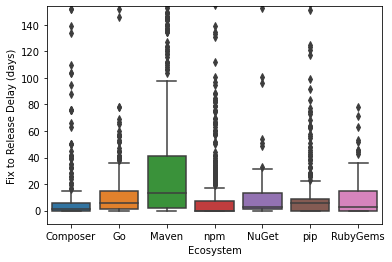

In [243]:
df= df[df['fix_to_release_delay'] >= 0]
ax = sns.boxplot(y='fix_to_release_delay', x='ecosystem', data = df, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems'])
ax.set(ylim =(-10,154), xlabel='Ecosystem', ylabel = 'Fix to Release Delay (days)')
plt.savefig('fix_to_release_delay.png',bbox_inches='tight')

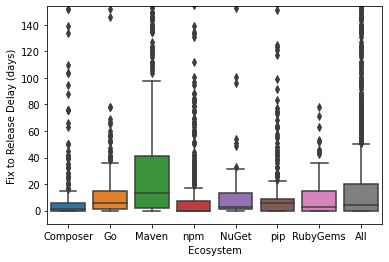

In [244]:
temp = df.copy()
temp['ecosystem'] = "All"
temp = pd.concat([temp, df], axis=0)
ax = sns.boxplot(y='fix_to_release_delay', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems', 'All'])
ax.set(ylim =(-10,154), xlabel='Ecosystem', ylabel = 'Fix to Release Delay (days)')
plt.savefig('fix_to_release_delay.png',bbox_inches='tight')

In [245]:
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,release_date,version,fixing_release,total_release,advisory_date,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31,2016-09-07 04:46:51,2016-09-07 16:06:06,2016-09-07 16:39:10,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3,2016-09-09,2016-09-07 16:06:06,0.0,1,2,2
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23,2021-01-13 22:15:05,2021-01-13 22:15:05,2021-01-25 16:29:19,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,2021-02-23,2021-01-13 22:15:05,12.0,-41,29,41
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20,2020-08-15 00:25:54,2020-08-15 00:25:54,2021-02-04 05:30:00,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating,2021-02-20,2020-08-15 00:25:54,173.0,-190,16,189
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19,2020-04-13 17:49:08,2020-04-28 18:20:50,2020-05-04 19:47:00,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4,2021-02-19,2020-04-28 18:20:50,6.0,-299,291,297
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19,2021-01-13 23:19:50,2021-01-13 23:19:50,2021-02-03 19:50:00,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14,2021-02-19,2021-01-13 23:19:50,21.0,-37,16,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-1070809,3926,pip,Improper Authorization,M,2021-02-08,2021-02-09,NaT,2021-02-04 19:46:52,2021-02-04 19:46:52,2021-02-04 20:01:20,1.3.0,package3926version1.3.0,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-107080939261...,2021-02-09,2021-02-04 19:46:52,0.0,-4,5,5
2785,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,2021-03-01 11:51:00,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0,2021-02-15,2021-01-26 14:00:30,34.0,0,-14,20
2786,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,NaT,2019-06-04 23:23:04,2019-06-04 23:23:04,2019-06-04 23:25:34,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-05,2019-06-04 23:23:04,0.0,0,1,1
2787,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,2019-01-22 10:10:02,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22,2019-01-22 08:42:56,0.0,0,0,0


In [246]:
usage = pd.merge(df, usage, on=['package_id', 'ecosystem'])
from scipy.stats import spearmanr
from scipy.stats import pearsonr
ecosystems = ['Composer','Go','Maven','npm','NuGet','pip','RubyGems']
l=[]
newl = []
for ecosystem in ecosystems:
    temp = usage[usage['ecosystem'] ==  ecosystem ]
    a = spearmanr(temp['fix_to_release_delay'], temp['dependent'])
    b = spearmanr(temp['fix_to_release_delay'], temp['dependent_repos'])
    l.append([ecosystem, a ,b])
    newl.append([ecosystem, round(a[0],2), round(b[0],2)])

l.append(['All', spearmanr(usage['fix_to_release_delay'], usage['dependent']), spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])])
newl.append(['All', round(spearmanr(usage['fix_to_release_delay'], usage['dependent'])[0],2), round(spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])[0],2)])
l

[['Composer',
  SpearmanrResult(correlation=-0.19274162798335198, pvalue=0.0008758277679639522),
  SpearmanrResult(correlation=-0.19313317663568705, pvalue=0.0008544152831027935)],
 ['Go',
  SpearmanrResult(correlation=-0.08512691206101582, pvalue=0.4527855063469092),
  SpearmanrResult(correlation=-0.03645625433061777, pvalue=0.7481729053274095)],
 ['Maven',
  SpearmanrResult(correlation=-0.23075387038431322, pvalue=3.342025940707579e-11),
  SpearmanrResult(correlation=-0.21477566588533084, pvalue=7.271081824157687e-10)],
 ['npm',
  SpearmanrResult(correlation=0.2654663405975448, pvalue=8.759755936018743e-12),
  SpearmanrResult(correlation=0.23257873707308407, pvalue=2.6140324297388564e-09)],
 ['NuGet',
  SpearmanrResult(correlation=0.2524220463037674, pvalue=0.028900944638176464),
  SpearmanrResult(correlation=0.15641045803445533, pvalue=0.1802233803982572)],
 ['pip',
  SpearmanrResult(correlation=0.050948907077986015, pvalue=0.2862582842167252),
  SpearmanrResult(correlation=0.006283

In [247]:
newl =  pd.DataFrame(newl, columns=['Ecosytem', 'Dependent Packages', 'Dependent Repositories'])
print(tabulate(newl, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrr}
\hline
 Ecosytem   &   Dependent Packages &   Dependent Repositories \\
\hline
 Composer   &                -0.19 &                    -0.19 \\
 Go         &                -0.09 &                    -0.04 \\
 Maven      &                -0.23 &                    -0.21 \\
 npm        &                 0.27 &                     0.23 \\
 NuGet      &                 0.25 &                     0.16 \\
 pip        &                 0.05 &                     0.01 \\
 RubyGems   &                -0.11 &                    -0.16 \\
 All        &                -0.05 &                    -0.09 \\
\hline
\end{tabular}


In [248]:
len(df[df['fix_to_release_delay']>= 500])
df['fix_to_release_delay'].describe()

count    2640.000000
mean       30.954924
std       115.271483
min         0.000000
25%         0.000000
50%         4.000000
75%        20.000000
max      2363.000000
Name: fix_to_release_delay, dtype: float64

In [249]:
npm =df[df['ecosystem']=='npm']
len(npm), len(npm[npm['fix_to_release_delay']==0])

(640, 322)

In [250]:
maven = df[df['ecosystem']=='Maven']
maven['fix_to_release_delay'].describe(), len(maven[maven['fix_to_release_delay']==0])

(count     807.000000
 mean       51.630731
 std       162.032630
 min         0.000000
 25%         2.000000
 50%        13.000000
 75%        41.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 121)

In [251]:
pbf = df[df['fix_to_publish_delay'] < 0]
pbf['release_to_publish_delay'].describe()

count     253.000000
mean     -117.833992
std       198.412939
min     -1196.000000
25%      -145.000000
50%       -32.000000
75%        -9.000000
max        -1.000000
Name: release_to_publish_delay, dtype: float64

In [252]:
pbr = df[(df['release_to_publish_delay'] < 0) & (df['fix_to_publish_delay'] >= 0)]
pbr['release_to_publish_delay'].describe()

count     296.000000
mean      -83.722973
std       229.225751
min     -2243.000000
25%       -63.250000
50%       -17.500000
75%        -5.750000
max        -1.000000
Name: release_to_publish_delay, dtype: float64

In [253]:
pub_before_release = df.groupby(['ecosystem','advisory_id'])[['release_to_publish_delay']].max()
pub_before_release = pub_before_release.reset_index()
pub_before_release = pub_before_release[pub_before_release['release_to_publish_delay'] < 0]
pub_before_release = len(pub_before_release)

pub_before_release = str(pub_before_release) + ' (' +  str(round(pub_before_release/df['advisory_id'].nunique()*100,1)) +'%)'
pub_before_fix = df.groupby(['ecosystem','advisory_id'])[['fix_to_publish_delay']].max()
pub_before_fix = pub_before_fix.reset_index()
pub_before_fix = pub_before_fix[pub_before_fix['fix_to_publish_delay'] < 0]
pub_before_fix = len(pub_before_fix)
pub_before_fix = str(pub_before_fix) + ' (' + str(round(pub_before_fix/df['advisory_id'].nunique()*100,1)) +'%)'
t = ['Total', df['advisory_id'].nunique(), df['package_id'].nunique(), df['fixing_release'].nunique(), 
total_cwes,
df['fix_to_release_delay'].median(),
df['total_release'].nunique(), pub_before_fix, pub_before_release ]
t[3] = str(t[3]) + ' (' + str(t[6]) +')'
del t[6]
t

['Total', 2001, 1342, '2240 (2640)', 143, 4.0, '202 (10.1%)', '449 (22.4%)']

In [254]:
gb = df.groupby('ecosystem')
eco_dfs = [(x,gb.get_group(x)) for x in gb.groups]
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')['fixing_release'].nunique()
total_rel = df.groupby('ecosystem')['total_release'].nunique()
fixrel = df.groupby('ecosystem')[['fix_to_release_delay']].median()

In [255]:
pub_before_release = df.groupby(['ecosystem','advisory_id'])[['release_to_publish_delay']].max()
pub_before_release = pub_before_release.reset_index()
pub_before_release = pub_before_release[pub_before_release['release_to_publish_delay'] < 0]
pub_before_release = pub_before_release.groupby('ecosystem')[['advisory_id']].nunique()
pub_before_release = pub_before_release.rename(columns={'advisory_id':'pub_before_release'})
pub_before_release

,pub_before_release
ecosystem,
Composer,27
Go,48
Maven,153
NuGet,14
RubyGems,15
npm,113
pip,79


In [256]:
pub_before_fix = df.groupby(['ecosystem','advisory_id'])[['fix_to_publish_delay']].max()
pub_before_fix = pub_before_fix.reset_index()
pub_before_fix = pub_before_fix[pub_before_fix['fix_to_publish_delay'] < 0]
pub_before_fix = pub_before_fix.groupby('ecosystem')[['advisory_id']].nunique()
pub_before_fix = pub_before_fix.rename(columns={'advisory_id':'pub_before_fix'})
pub_before_fix

,pub_before_fix
ecosystem,
Composer,13
Go,21
Maven,40
NuGet,8
RubyGems,9
npm,72
pip,39


In [257]:
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel,cwe, fixrel, pub_before_fix,pub_before_release, total_rel])
final = final.reset_index()
final['fixing_release'] = final['fixing_release'].map(str) +  ' (' + final['total_release'].map(str) +')'
final

,ecosystem,advisory_id,package_id,fixing_release,cwe,fix_to_release_delay,pub_before_fix,pub_before_release,total_release
0,Composer,183,93,204 (295),40,1.0,13,27,295
1,Go,184,150,224 (242),46,6.0,21,48,242
2,Maven,574,385,745 (807),83,13.0,40,153,807
3,NuGet,70,22,52 (75),10,3.0,8,14,75
4,RubyGems,113,80,121 (139),41,3.0,9,15,139
5,npm,553,412,586 (640),72,0.0,72,113,640
6,pip,324,200,308 (442),68,6.0,39,79,442


In [258]:
q = 'select * from advisoryCWE'
cwe = pd.DataFrame(sql.execute(q))
df = df.merge(cwe, on='advisory_id')
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,cve_date,earliest_fix_commit_date,latest_fix_commit_date,...,version,fixing_release,total_release,advisory_date,fix_commit_date,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay,cwe
0,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2018-05-31,2016-09-07 04:46:51,2016-09-07 16:06:06,...,2.4.3,package20version2.4.3,npm:nunjucks:20160906202.4.3,2016-09-09,2016-09-07 16:06:06,0.0,1,2,2,CWE-79
1,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,35,Go,Information Exposure,L,2021-02-23,2021-02-23,2021-02-23,2021-01-13 22:15:05,2021-01-13 22:15:05,...,5.6.0,package35version5.6.0,SNYK-GOLANG-GITHUBCOMKEYBASECLIENTGOCHATATTACH...,2021-02-23,2021-01-13 22:15:05,12.0,-41,29,41,CWE-200
2,SNYK-JAVA-ORGAPACHELIVY-1078231,36,Maven,Cross-site Scripting (XSS),H,2021-02-21,2021-02-21,2021-02-20,2020-08-15 00:25:54,2020-08-15 00:25:54,...,0.7.1-incubating,package36version0.7.1-incubating,SNYK-JAVA-ORGAPACHELIVY-1078231360.7.1-incubating,2021-02-20,2020-08-15 00:25:54,173.0,-190,16,189,CWE-79
3,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235,42,Maven,Information Exposure,H,2021-02-21,2021-02-21,2021-02-19,2020-04-13 17:49:08,2020-04-28 18:20:50,...,2.5.4,package42version2.5.4,SNYK-JAVA-COMHUBSPOTJINJAVA-1078235422.5.4,2021-02-19,2020-04-28 18:20:50,6.0,-299,291,297,CWE-200
4,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798,44,Maven,Cross-site Request Forgery (CSRF),M,2021-02-19,2021-02-19,2021-02-19,2021-01-13 23:19:50,2021-01-13 23:19:50,...,2.2.14,package44version2.2.14,SNYK-JAVA-ORGAPACHEMYFACESCORE-1076798442.2.14,2021-02-19,2021-01-13 23:19:50,21.0,-37,16,37,CWE-352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-1070809,3926,pip,Improper Authorization,M,2021-02-08,2021-02-09,NaT,2021-02-04 19:46:52,2021-02-04 19:46:52,...,1.3.0,package3926version1.3.0,SNYK-PYTHON-DYNAMODBENCRYPTIONSDK-107080939261...,2021-02-09,2021-02-04 19:46:52,0.0,-4,5,5,CWE-285
2726,SNYK-JAVA-COMVAADIN-1074927,3932,Maven,Timing Attack,M,2021-01-26,2021-02-15,NaT,2021-01-25 13:03:00,2021-01-26 14:00:30,...,6.0.0,package3932version6.0.0,SNYK-JAVA-COMVAADIN-107492739326.0.0,2021-02-15,2021-01-26 14:00:30,34.0,0,-14,20,CWE-208
2727,SNYK-JS-APOLLOGATEWAY-174915,1852,npm,Prototype Pollution,H,2019-06-04,2019-06-05,NaT,2019-06-04 23:23:04,2019-06-04 23:23:04,...,0.6.2,package1852version0.6.2,SNYK-JS-APOLLOGATEWAY-17491518520.6.2,2019-06-05,2019-06-04 23:23:04,0.0,0,1,1,CWE-400
2728,SNYK-PHP-TYPO3CMS-73594,272,Composer,Security Misconfiguration,H,2019-01-22,2019-01-22,NaT,2019-01-22 08:42:56,2019-01-22 08:42:56,...,8.7.23,package272version8.7.23,SNYK-PHP-TYPO3CMS-735942728.7.23,2019-01-22,2019-01-22 08:42:56,0.0,0,0,0,CWE-288


In [259]:

final.columns = ['ecosystem','advisory','package','releases', 'cwe', 'fix_to_release','publish_before_fix', 'publish_before_release', 'total_release']
final['temp'] = final['publish_before_release'] 
final['publish_before_release'] =  round(final['publish_before_release'] / final['advisory'] * 100, 1)
final['publish_before_release'] = final['temp'].map(str) + ' (' + final['publish_before_release'].map(str) + '%)'
final['temp'] = final['publish_before_fix'] 
final['publish_before_fix'] =  round(final['publish_before_fix'] / final['advisory'] * 100, 1)
final['publish_before_fix'] = final['temp'].map(str) + ' (' + final['publish_before_fix'].map(str) + '%)'
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop(['temp','total_release'], axis=1)
final.loc[len(final)]  = t
final

,ecosystem,advisory,package,releases,cwe,fix_to_release,publish_before_fix,publish_before_release
0,Composer,183,93,204 (295),40,1.0,13 (7.1%),27 (14.8%)
1,Go,184,150,224 (242),46,6.0,21 (11.4%),48 (26.1%)
2,Maven,574,385,745 (807),83,13.0,40 (7.0%),153 (26.7%)
5,npm,553,412,586 (640),72,0.0,72 (13.0%),113 (20.4%)
3,NuGet,70,22,52 (75),10,3.0,8 (11.4%),14 (20.0%)
6,pip,324,200,308 (442),68,6.0,39 (12.0%),79 (24.4%)
4,RubyGems,113,80,121 (139),41,3.0,9 (8.0%),15 (13.3%)
7,Total,2001,1342,2240 (2640),143,4.0,202 (10.1%),449 (22.4%)


In [260]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrlrrll}
\hline
 ecosystem   &   advisory &   package & releases    &   cwe &   fix\_to\_release & publish\_before\_fix   & publish\_before\_release   \\
\hline
 Composer    &        183 &        93 & 204 (295)   &    40 &                1 & 13 (7.1\%)            & 27 (14.8\%)               \\
 Go          &        184 &       150 & 224 (242)   &    46 &                6 & 21 (11.4\%)           & 48 (26.1\%)               \\
 Maven       &        574 &       385 & 745 (807)   &    83 &               13 & 40 (7.0\%)            & 153 (26.7\%)              \\
 npm         &        553 &       412 & 586 (640)   &    72 &                0 & 72 (13.0\%)           & 113 (20.4\%)              \\
 NuGet       &         70 &        22 & 52 (75)     &    10 &                3 & 8 (11.4\%)            & 14 (20.0\%)               \\
 pip         &        324 &       200 & 308 (442)   &    68 &                6 & 39 (12.0\%)           & 79 (24.4\%)               \\
 RubyGems    &    

In [261]:
shuffled = df[df['fix_to_release_delay'] > 20]
shuffled = shuffled.sample(frac=1).reset_index(drop=True)
shuffled.to_csv('rq1_fourth_quartile.csv')

In [262]:
# q='select * from fix_commits where commit_date is not null'
# df = pd.DataFrame(sql.execute(q))
# df['auth_commit_delay'] = (df['commit_date'].dt.date - df['author_date'].dt.date).dt.days
# df['auth_commit_delay'].describe()
# print(len(df))
# df = df[df['auth_commit_delay'] > 0]
# len(df)

In [263]:
high, medium, low = df[df['severity']=='H'], df[df['severity']=='M'], df[df['severity']=='L']
high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(count    1201.000000
 mean       27.214821
 std        90.554342
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        16.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1380.000000
 mean       33.289130
 std       116.745826
 min         0.000000
 25%         0.000000
 50%         5.000000
 75%        25.000000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     149.00000
 mean       46.61745
 std       233.17412
 min         0.00000
 25%         0.00000
 50%         3.00000
 75%        14.00000
 max      2363.00000
 Name: fix_to_release_delay, dtype: float64)

In [264]:

from scipy.stats import mannwhitneyu
mannwhitneyu(high['fix_to_release_delay'],medium['fix_to_release_delay']), mannwhitneyu(high['fix_to_release_delay'],low['fix_to_release_delay']), mannwhitneyu(medium['fix_to_release_delay'],low['fix_to_release_delay']), high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(MannwhitneyuResult(statistic=780357.5, pvalue=0.004585319606954429),
 MannwhitneyuResult(statistic=87231.5, pvalue=0.3051806077068462),
 MannwhitneyuResult(statistic=98661.5, pvalue=0.20540886781767842),
 count    1201.000000
 mean       27.214821
 std        90.554342
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        16.000000
 max      1758.000000
 Name: fix_to_release_delay, dtype: float64,
 count    1380.000000
 mean       33.289130
 std       116.745826
 min         0.000000
 25%         0.000000
 50%         5.000000
 75%        25.000000
 max      1734.000000
 Name: fix_to_release_delay, dtype: float64,
 count     149.00000
 mean       46.61745
 std       233.17412
 min         0.00000
 25%         0.00000
 50%         3.00000
 75%        14.00000
 max      2363.00000
 Name: fix_to_release_delay, dtype: float64)

In [265]:
q = '''select advisory_id, package_id, ecosystem, min(release_date) as first,
       max(release_date) as last
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id
            and fcd.advisory_id in
    (select advisory_id from
(select advisory_id, count(*)
from
(select advisory_id, min(commit_date) as fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where commit_date is not null
group by advisory_id) as fcd
join
(select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id
group by advisory_id
having count(*) > 1) as sub)
group by advisory_id, package_id, ecosystem;
'''
multiple_rel = pd.DataFrame(sql.execute(q))
multiple_rel['range'] = (multiple_rel['last'].dt.date - multiple_rel['first'].dt.date).dt.days
multiple_rel['range'].describe(), len(multiple_rel[multiple_rel['range']==0])

(count     392.000000
 mean       61.946429
 std       227.415502
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         8.000000
 max      1718.000000
 Name: range, dtype: float64,
 203)

In [266]:
multiple_rel = multiple_rel[multiple_rel['range'] > 0 ]
multiple_rel['range'].describe()

count     189.000000
mean      128.481481
std       314.591877
min         1.000000
25%         3.000000
50%         8.000000
75%        55.000000
max      1718.000000
Name: range, dtype: float64

In [267]:
print(len(df), len(ifcve))
df= pd.merge(df, ifcve, on='advisory_id')
len(df)

2730 6956


2730

In [268]:
cve = df[df['ifcve']=='cve']
noncve = df[df['ifcve']=='noncve']
print(len(cve), len(noncve))

2041 689


In [269]:
cve['fix_to_release_delay'].describe(), noncve['fix_to_release_delay'].describe()

(count    2041.000000
 mean       26.777560
 std       108.444445
 min         0.000000
 25%         0.000000
 50%         4.000000
 75%        18.000000
 max      2363.000000
 Name: fix_to_release_delay, dtype: float64,
 count     689.000000
 mean       44.872279
 std       135.238220
 min         0.000000
 25%         0.000000
 50%         3.000000
 75%        26.000000
 max      1341.000000
 Name: fix_to_release_delay, dtype: float64)

In [270]:
mannwhitneyu(cve['fix_to_release_delay'],noncve['fix_to_release_delay'].describe())

MannwhitneyuResult(statistic=5346.0, pvalue=0.043378333849292613)

In [271]:
q = '''select a.id as advisory_id, a.severity, p.id as package_id, p.ecosystem, a.publish_date as snyk_date, ac.cve_date, min(ri.publish_date) as release_date
from advisory a
    left join (select advisory_id, min(C.publish_Date) as cve_date
from advisoryCVE aC
join CVE C on aC.cve = C.cve
group by advisory_id) as ac
    on ac.advisory_id=a.id
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and fr.version=ri.version
where ri.publish_date is not null
group by a.id;'''
df = pd.DataFrame(sql.execute(q))
len(df)

3655

In [272]:
df['cve_date'] = df['cve_date'].dt.date
t1 = df[~df['cve_date'].isna()].copy()
t1['advisory_date'] = t1[['cve_date', 'snyk_date']].min(axis=1)
t2 = df[df['cve_date'].isna()].copy()
t2['advisory_date'] = t2['snyk_date']
df = pd.concat([t1, t2], ignore_index=True, sort=False)
len(df)

3655

In [273]:
df['rtp_delay'] = (df['advisory_date'] - df['release_date'].dt.date).dt.days

In [274]:
'''The start of analysis of RQ4'''

'The start of analysis of RQ4'

In [275]:
df['advisory_id'].nunique()

3655

In [276]:
total_adv = df.groupby('ecosystem')[['advisory_id']].nunique()
total_c = df['advisory_id'].nunique()
total_adv

,advisory_id
ecosystem,
Composer,751
Go,211
Maven,937
NuGet,241
RubyGems,211
npm,735
pip,569


In [277]:
df = df[df['rtp_delay'] > 0]
len(df)

2527

In [278]:
usage = pd.merge(df, usage, on=['package_id', 'ecosystem'])
from scipy.stats import spearmanr
from scipy.stats import pearsonr
ecosystems = ['Composer','Go','Maven','npm','NuGet','pip','RubyGems']
l=[]
newl = []
for ecosystem in ecosystems:
    temp = usage[usage['ecosystem'] ==  ecosystem ]
    a = spearmanr(temp['rtp_delay'], temp['dependent'])
    b = spearmanr(temp['rtp_delay'], temp['dependent_repos'])
    l.append([ecosystem, a ,b])
    newl.append([ecosystem, round(a[0],2), round(b[0],2)])

l.append(['All', spearmanr(usage['fix_to_release_delay'], usage['dependent']), spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])])
newl.append(['All', round(spearmanr(usage['fix_to_release_delay'], usage['dependent'])[0],2), round(spearmanr(usage['fix_to_release_delay'], usage['dependent_repos'])[0],2)])
l

[['Composer',
  SpearmanrResult(correlation=0.22947372843071864, pvalue=1.4011336790900563e-37),
  SpearmanrResult(correlation=0.23878867769686102, pvalue=1.2245340876850883e-40)],
 ['Go',
  SpearmanrResult(correlation=-0.2130770725109339, pvalue=0.027554655662997262),
  SpearmanrResult(correlation=-0.19177043317796977, pvalue=0.047838998326943015)],
 ['Maven',
  SpearmanrResult(correlation=0.10628045765874258, pvalue=1.9121479356311156e-11),
  SpearmanrResult(correlation=-0.02324299817617917, pvalue=0.1431815397604785)],
 ['npm',
  SpearmanrResult(correlation=0.04873700798480015, pvalue=0.015481046450912894),
  SpearmanrResult(correlation=0.07887603804556997, pvalue=8.788556667860263e-05)],
 ['NuGet',
  SpearmanrResult(correlation=0.05950674532518787, pvalue=0.0066729690662167785),
  SpearmanrResult(correlation=0.02597233893266331, pvalue=0.2367483633239173)],
 ['pip',
  SpearmanrResult(correlation=-0.16311173491797243, pvalue=3.2467047484408382e-18),
  SpearmanrResult(correlation=-0.

In [279]:
df

,advisory_id,severity,package_id,ecosystem,snyk_date,cve_date,release_date,advisory_date,rtp_delay
0,npm:adm-zip:20180415,H,2289,npm,2018-05-31,2018-07-25,2018-05-12 22:25:41,2018-05-31,19
1,npm:aerospike:20161101,H,2956,npm,2016-12-06,2018-05-29,2016-11-10 09:53:49,2016-12-06,26
2,npm:angular-http-server:20180302,H,2421,npm,2018-03-08,2018-06-07,2018-01-27 14:07:58,2018-03-08,40
3,npm:angular-jwt:20180605,M,2185,npm,2018-08-16,2018-06-19,2018-05-30 16:11:54,2018-06-19,20
4,npm:anywhere:20180226,H,2408,npm,2018-03-06,2018-06-07,2018-02-18 16:15:32,2018-03-06,16
...,...,...,...,...,...,...,...,...,...
3649,SNYK-JAVA-ORGWEBJARSNPM-480133,H,3382,Maven,2017-01-18,NaT,2015-10-24 02:13:00,2017-01-18,452
3650,SNYK-JAVA-ORGWEBJARSNPM-1014643,M,187,Maven,2020-10-01,NaT,2020-09-22 23:57:00,2020-10-01,9
3651,SNYK-JAVA-ORGAPACHEFELIX-174782,M,1862,Maven,2019-05-26,NaT,2019-05-21 16:59:00,2019-05-26,5
3652,SNYK-JAVA-IOSPRAY-30442,H,3019,Maven,2016-08-15,NaT,2015-03-24 17:51:00,2016-08-15,510


In [280]:
df['rtp_delay'].describe()

count    2527.000000
mean      199.167392
std       453.159883
min         1.000000
25%         5.000000
50%        25.000000
75%       148.000000
max      4918.000000
Name: rtp_delay, dtype: float64

In [281]:
h = df[df['severity'] == 'H']
h['rtp_delay'].describe()

count    1093.000000
mean      171.696249
std       450.387437
min         1.000000
25%         3.000000
50%        20.000000
75%       105.000000
max      4918.000000
Name: rtp_delay, dtype: float64

In [282]:
m = df[df['severity'] == 'M']
m['rtp_delay'].describe()

count    1326.000000
mean      219.257919
std       448.093231
min         1.000000
25%         7.000000
50%        33.500000
75%       178.000000
max      3603.000000
Name: rtp_delay, dtype: float64

In [283]:
l = df[df['severity'] == 'L']
l['rtp_delay'].describe()

count     108.000000
mean      230.518519
std       526.878082
min         1.000000
25%         3.000000
50%        25.500000
75%       165.500000
max      4301.000000
Name: rtp_delay, dtype: float64

In [284]:
mannwhitneyu(h['rtp_delay'], m['rtp_delay'])

MannwhitneyuResult(statistic=617888.5, pvalue=2.030943226859811e-10)

In [285]:
mannwhitneyu(h['rtp_delay'], l['rtp_delay'])

MannwhitneyuResult(statistic=55035.0, pvalue=0.12268004236053204)

In [286]:
random = df.sample(frac=1)
random.to_csv('rtpdelay.csv')

In [287]:
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
delay = df.groupby('ecosystem')[['rtp_delay']].median()

In [288]:
final = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[total_adv, adv, delay])
final = final.reset_index()
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop(['temp'], axis=1)
All = ['All', total_c,  df['advisory_id'].nunique(), df['rtp_delay'].median()]
final.loc[len(final)]=All
final

,ecosystem,advisory_id_x,advisory_id_y,rtp_delay
0,Composer,751,509,21.0
1,Go,211,145,15.0
2,Maven,937,693,43.0
5,npm,735,540,24.0
3,NuGet,241,150,2.0
6,pip,569,367,19.0
4,RubyGems,211,123,167.0
7,All,3655,2527,25.0


In [289]:
final = final.rename(columns={'advisory_id_x':'a', 'advisory_id_y':'ar', })

In [290]:

final['p'] = round(final['ar']/final['a']*100,1)
final['ar'] = final['ar'].map(str) + ' (' + final['p'].map(str) + '%)'
final = final.drop('p', axis=1)

In [291]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrlr}
\hline
 ecosystem   &    a & ar           &   rtp\_delay \\
\hline
 Composer    &  751 & 509 (67.8\%)  &          21 \\
 Go          &  211 & 145 (68.7\%)  &          15 \\
 Maven       &  937 & 693 (74.0\%)  &          43 \\
 npm         &  735 & 540 (73.5\%)  &          24 \\
 NuGet       &  241 & 150 (62.2\%)  &           2 \\
 pip         &  569 & 367 (64.5\%)  &          19 \\
 RubyGems    &  211 & 123 (58.3\%)  &         167 \\
 All         & 3655 & 2527 (69.1\%) &          25 \\
\hline
\end{tabular}


In [292]:
temp = df.copy()
temp['ecosystem'] = "All"
temp = pd.concat([temp, df], axis=0)

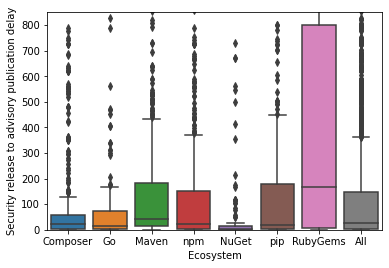

In [293]:
ax = sns.boxplot(y='rtp_delay', x='ecosystem', data = temp, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems', 'All'])
ax.set(ylim=(0,850), xlabel='Ecosystem', ylabel='Security release to advisory publication delay')
plt.savefig('rtp_delay.png',bbox_inches='tight')

In [294]:
df

,advisory_id,severity,package_id,ecosystem,snyk_date,cve_date,release_date,advisory_date,rtp_delay
0,npm:adm-zip:20180415,H,2289,npm,2018-05-31,2018-07-25,2018-05-12 22:25:41,2018-05-31,19
1,npm:aerospike:20161101,H,2956,npm,2016-12-06,2018-05-29,2016-11-10 09:53:49,2016-12-06,26
2,npm:angular-http-server:20180302,H,2421,npm,2018-03-08,2018-06-07,2018-01-27 14:07:58,2018-03-08,40
3,npm:angular-jwt:20180605,M,2185,npm,2018-08-16,2018-06-19,2018-05-30 16:11:54,2018-06-19,20
4,npm:anywhere:20180226,H,2408,npm,2018-03-06,2018-06-07,2018-02-18 16:15:32,2018-03-06,16
...,...,...,...,...,...,...,...,...,...
3649,SNYK-JAVA-ORGWEBJARSNPM-480133,H,3382,Maven,2017-01-18,NaT,2015-10-24 02:13:00,2017-01-18,452
3650,SNYK-JAVA-ORGWEBJARSNPM-1014643,M,187,Maven,2020-10-01,NaT,2020-09-22 23:57:00,2020-10-01,9
3651,SNYK-JAVA-ORGAPACHEFELIX-174782,M,1862,Maven,2019-05-26,NaT,2019-05-21 16:59:00,2019-05-26,5
3652,SNYK-JAVA-IOSPRAY-30442,H,3019,Maven,2016-08-15,NaT,2015-03-24 17:51:00,2016-08-15,510


In [295]:
total = df.groupby('ecosystem')[['advisory_id']].nunique()
total

,advisory_id
ecosystem,
Composer,509
Go,145
Maven,693
NuGet,150
RubyGems,123
npm,540
pip,367


In [296]:
cve = df[~df['cve_date'].isna()]
cve['rtp_delay'].median(), len(cve)

(21.0, 1850)

In [297]:
noncve = df[df['cve_date'].isna()]
noncve['rtp_delay'].median()

55.0

In [298]:
mannwhitneyu(cve['rtp_delay'], noncve['rtp_delay'])

MannwhitneyuResult(statistic=464128.0, pvalue=8.438916751847408e-24)

In [299]:
len(cve), len(noncve)

(1850, 677)

In [224]:
cve_count = cve.groupby('ecosystem')[['advisory_id']].nunique()
cve_delay = cve.groupby('ecosystem')[['rtp_delay']].median()
noncve_count = noncve.groupby('ecosystem')[['advisory_id']].nunique()
noncve_delay = noncve.groupby('ecosystem')[['rtp_delay']].median()
cvenoncve = reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[ cve_count, cve_delay, noncve_count, noncve_delay])
cvenoncve = cvenoncve.reset_index()
cvenoncve

,ecosystem,advisory_id_x,rtp_delay_x,advisory_id_y,rtp_delay_y
0,Composer,355,18,154,21.0
1,Go,121,13,24,33.5
2,Maven,601,41,92,100.0
3,NuGet,134,2,16,127.0
4,RubyGems,82,42,41,948.0
5,npm,307,13,233,56.0
6,pip,250,7,117,187.0


In [225]:
print(tabulate(cvenoncve, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrr}
\hline
 ecosystem   &   advisory\_id\_x &   rtp\_delay\_x &   advisory\_id\_y &   rtp\_delay\_y \\
\hline
 Composer    &             355 &            18 &             154 &          21   \\
 Go          &             121 &            13 &              24 &          33.5 \\
 Maven       &             601 &            41 &              92 &         100   \\
 NuGet       &             134 &             2 &              16 &         127   \\
 RubyGems    &              82 &            42 &              41 &         948   \\
 npm         &             307 &            13 &             233 &          56   \\
 pip         &             250 &             7 &             117 &         187   \\
\hline
\end{tabular}


In [709]:
df['release_year'] = df['release_date'].dt.year
df.groupby('release_year')[['rtp_delay']].median()

,rtp_delay
release_year,
2005,855.0
2006,7.0
2008,3493.0
2009,539.5
2010,948.0
2011,528.0
2012,269.0
2013,148.0
2014,170.5


In [710]:
usage.groupby('ecosystem')[['dependent_repos']].median()

,dependent_repos
ecosystem,
Composer,293.0
Go,0.0
Maven,328.0
NuGet,39.0
RubyGems,9593.0
npm,1772.0
pip,1275.5


In [711]:
cve['cvedelay'] = (cve['cve_date'] - cve['snyk_date']).dt.days
cve['cvedelay'].describe()
cve

<ipython-input-711-b0388dd92ad4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cve['cvedelay'] = (cve['cve_date'] - cve['snyk_date']).dt.days


,advisory_id,severity,ecosystem,snyk_date,cve_date,release_date,advisory_date,rtp_delay,cvedelay
0,npm:adm-zip:20180415,H,npm,2018-05-31,2018-07-25,2018-05-12 22:25:41,2018-05-31,19,55
1,npm:aerospike:20161101,H,npm,2016-12-06,2018-05-29,2016-11-10 09:53:49,2016-12-06,26,539
2,npm:angular-http-server:20180302,H,npm,2018-03-08,2018-06-07,2018-01-27 14:07:58,2018-03-08,40,91
3,npm:angular-jwt:20180605,M,npm,2018-08-16,2018-06-19,2018-05-30 16:11:54,2018-06-19,20,-58
4,npm:anywhere:20180226,H,npm,2018-03-06,2018-06-07,2018-02-18 16:15:32,2018-03-06,16,93
...,...,...,...,...,...,...,...,...,...
2651,SNYK-RUBY-ARCHIVETARMINITAR-20337,H,RubyGems,2017-03-06,2017-02-01,2009-07-25 18:33:51,2017-02-01,2748,-33
2652,SNYK-RUBY-HAMMERCLI-20453,H,RubyGems,2017-05-22,2018-03-12,2017-03-28 14:37:07,2017-05-22,55,294
2654,SNYK-RUBY-RUBYOPENID-536103,M,RubyGems,2019-11-29,2013-12-12,2012-10-23 09:07:50,2013-12-12,415,-2178
2656,SNYK-RUBY-RAKE-552000,H,RubyGems,2020-02-24,2020-02-24,2019-07-22 01:30:40,2020-02-24,217,0
